# **Evaluación de algoritmos de Machine Learning supervisado en un conjunto de datos de fraude energético**

### **Introducción**

El presente proyecto busca clasificar, de forma efectiva, hogares que defraudan a la compañía eléctrica de los que no, evaluando el desempeño algoritmos de aprendizaje supervisado.

Para efecto, contamos con un conjunto de datos cuyas variables características son el consumo diario de energía eléctrica de 9957 hogares. La variable objetivo es de carácter binario, e indica cuáles hogares se detectaron como defraudadores (1) y cuáles no (0).

La selección de las métricas a utilizar dependerá de los objetivos específicos del proyecto y del equilibrio que se desee encontrar entre Precisión y Recall. Por ejemplo, si el costo de identificar un hogar que no defrauda a la compañía eléctrica como un hogar que sí defrauda es muy alto, entonces se debe priorizar Recall sobre Precision. Por otro lado, si el costo de identificar un hogar que defrauda a la compañía eléctrica como un hogar que no defrauda es muy alto, entonces se debe priorizar Precision sobre Recall.

Dado que el objetivo principal del proyecto es "optimizar las limitadas visitas comerciales a aquellos hogares que realmente son fraudulentos", hemos decidido que la métrica a tomar en cuenta para el objetivo de este proyecto será la **Precisión**. Sin embargo, también tomaremos en cuenta el Recall dentro de la obtención de métricas de los modelos evaluados.

A la par, para evaluar la capacidad de generalización de los modelos, revisaremos los valores de Error Cuadrado Medio (MSE) de cada uno. Calcularemos el MSE de validación cruzada así como el obtenido en los conjuntos de entrenamiento `train_mse` y evaluación `test_mse`. Cosideraremos los modelos con menor valor de `train_mse - test_mse` como aquellos con menor sobreajuste, es decir, mejor capacidad de generalización.

### **Etapa previa**

In [1]:
# Importar librerías relevantes:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.impute import SimpleImputer
from sklearn.metrics import recall_score, precision_score, make_scorer, mean_squared_error
from sklearn.model_selection import train_test_split, RandomizedSearchCV, GridSearchCV, cross_val_score
from sklearn.ensemble import RandomForestClassifier, VotingClassifier, BaggingClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
import xgboost as xgb

El conjunto de datos que utilizaremos fue obtenido en:

https://www.kaggle.com/datasets/avinemmatty/theft-data

In [2]:
# Importar dataset:
electricity_data = pd.read_csv('Electricity_Theft_Data.csv', index_col=['CONS_NO'])

In [42]:
electricity_data.describe()

,01-01-15,02-01-15,03-01-15,04-01-15,05-01-15,06-01-15,07-01-15,08-01-15,09-01-15,10-01-15,...,23-12-15,24-12-15,25-12-15,26-12-15,27-12-15,28-12-15,29-12-15,30-12-15,31-12-15,CHK_STATE
count,8355.000000,8355.000000,8355.000000,8356.000000,8357.000000,8358.000000,8360.000000,8363.000000,8363.000000,8363.000000,...,9946.000000,9947.000000,9946.000000,9947.000000,9947.000000,9947.000000,9950.000000,9950.000000,9955.000000,9956.000000
mean,6.659159,6.700741,6.846346,6.577144,6.517476,6.431009,5.935722,7.103165,6.580208,6.761536,...,7.468988,6.655248,6.743952,6.155237,6.744348,5.315301,5.560368,5.520999,5.517219,0.140016
std,11.668277,11.445378,11.741275,11.837118,11.996402,12.376089,53.196175,53.057456,11.655925,14.387630,...,29.455950,57.146371,61.794120,89.771570,86.381172,116.945584,127.731367,147.273463,187.331815,0.347021
min,-104.550000,-50.773333,0.000000,0.000000,0.000000,0.000000,-4716.660000,0.000000,0.000000,0.000000,...,-1694.621500,-3738.970000,-3738.970000,-5608.423333,-5608.423333,-5944.019000,-7112.985000,-10674.812500,-14236.640000,0.000000
25%,0.500000,0.500000,0.560000,0.580000,0.600000,0.550000,0.530000,0.560000,0.575000,0.570000,...,0.750000,0.710000,0.730000,0.705000,0.695000,0.695000,0.720000,0.690000,0.770000,0.000000
50%,4.230000,4.290000,4.350000,4.130000,4.220000,4.100000,4.150000,4.060000,4.160000,4.270000,...,4.550000,4.510000,4.610000,4.720000,4.860000,4.590000,4.670000,4.710000,4.760000,0.000000
75%,9.200000,9.135000,9.390000,8.800000,8.670000,8.510000,8.570000,8.570000,8.815000,9.130000,...,9.147500,9.070000,9.250000,9.570000,9.880000,9.280000,9.557500,9.520000,9.570000,0.000000
max,312.090000,355.450000,400.860000,332.160000,363.620000,406.850000,411.920000,4720.090000,306.510000,815.640000,...,681.930000,661.300000,698.280000,762.980000,749.420000,766.080000,818.880000,767.330000,4367.701667,1.000000


#### **Pretratamiento de datos**

Notamos que hay valores faltantes, por lo que imputaremos. Experimentamos con dos estrategias: SimpleImputer y KNNImputer. De forma general, la técnica de imputación simple de mediana entregó mejores resultados de clasificación que la imputación KNN.

In [3]:
# Crear un objeto SimpleImputer, ajustar y transformar el conjunto de datos
imputer = SimpleImputer(strategy='median')
electricity_data_imputed = pd.DataFrame(imputer.fit_transform(electricity_data),
                                        columns=electricity_data.columns)

In [12]:
electricity_data_imputed.describe()

,01-01-15,02-01-15,03-01-15,04-01-15,05-01-15,06-01-15,07-01-15,08-01-15,09-01-15,10-01-15,...,24-12-15,25-12-15,26-12-15,27-12-15,28-12-15,29-12-15,30-12-15,31-12-15,CHK_STATE,mean_daily_consumption
count,9957.000000,9957.000000,9957.000000,9957.000000,9957.000000,9957.000000,9957.000000,9957.000000,9957.000000,9957.000000,...,9957.000000,9957.000000,9957.000000,9957.000000,9957.000000,9957.000000,9957.000000,9957.000000,9957.000000,9957.000000
mean,6.268327,6.312873,6.444705,6.183664,6.148292,6.056671,5.649311,6.615990,6.192761,6.362670,...,6.653093,6.741594,6.153796,6.742456,5.314572,5.559742,5.520428,5.517067,0.140002,24.044582
std,10.725577,10.521547,10.794284,10.880882,11.022599,11.371032,48.747727,48.637742,10.718973,13.217278,...,57.117705,61.760014,89.726486,86.337800,116.886840,127.686458,147.221682,187.312999,0.347007,12.670696
min,-104.550000,-50.773333,0.000000,0.000000,0.000000,0.000000,-4716.660000,0.000000,0.000000,0.000000,...,-3738.970000,-3738.970000,-5608.423333,-5608.423333,-5944.019000,-7112.985000,-10674.812500,-14236.640000,0.000000,-130.317041
25%,1.050000,1.030000,1.150000,1.130000,1.170000,1.100000,1.090000,1.070000,1.080000,1.120000,...,0.710000,0.730000,0.710000,0.700000,0.700000,0.720000,0.700000,0.770000,0.000000,19.301945
50%,4.230000,4.290000,4.350000,4.130000,4.220000,4.100000,4.150000,4.060000,4.160000,4.270000,...,4.510000,4.610000,4.720000,4.860000,4.590000,4.670000,4.710000,4.760000,0.000000,22.326356
75%,8.130000,8.080000,8.260000,7.770000,7.650000,7.520000,7.580000,7.540000,7.730000,8.010000,...,9.060000,9.250000,9.570000,9.870000,9.270000,9.550000,9.510000,9.570000,0.000000,26.011260
max,312.090000,355.450000,400.860000,332.160000,363.620000,406.850000,411.920000,4720.090000,306.510000,815.640000,...,661.300000,698.280000,762.980000,749.420000,766.080000,818.880000,767.330000,4367.701667,1.000000,308.545918


Algo curioso de este conjunto de datos es que la presencia de valores negativos, lo cual en primera instancia parecería extraño si se trata de consumo energía. Sin embargo, decidimos dejar estos valores porque pueden formar parte del fraude de robo de energía: los valores negativos pueden ocurrir si los medidores de los hogares defraudadores están trucados.

In [4]:
# Obtener las variables características (X) y variable objetivo (y):
X = electricity_data_imputed.drop('CHK_STATE', axis=1)
y= electricity_data_imputed['CHK_STATE']

# Dividir el dataset en subconjuntos de entrenamiento y evaluación: 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.3, random_state=123)

#### **Análisis Exploratorio de datos**

Con el EDA, queremos responder la pregunta: qué hogares consumen más energía: los "defraudadores" o los que no lo son? De exisitir una diferencia, es esta estadísticamente significativa?

Primero, graficamos la distribución del consumo medio por clases: 

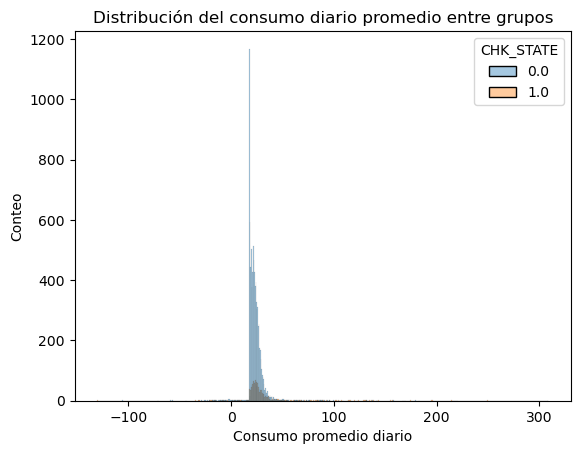

In [10]:
# Obtener el consumo de eletricidad medio diario:
electricity_data_imputed['mean_daily_consumption'] = X.mean(axis=1)

# Graficar por clases:
sns.histplot(x='mean_daily_consumption', data=electricity_data_imputed, hue='CHK_STATE', alpha=0.4)
plt.xlabel("Consumo promedio diario")
plt.ylabel("Conteo")
plt.title("Distribución del consumo diario promedio entre grupos")
plt.show()

Con la excepción de notar el claro desbalance entre clases, debido a la distribución de los datos resulta muy difícil observar diferencias entre clases en el histograma.

En este caso, resultaría mejor observar y comparar la función de distribución acumulada empírica por clase (ECDF):

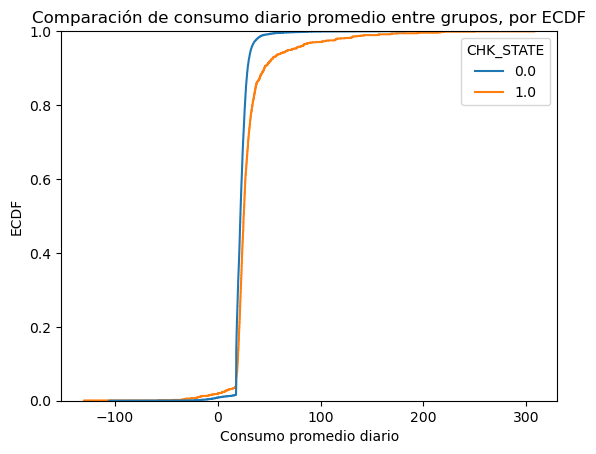

In [11]:
# Graficar ECDF:
sns.ecdfplot(x='mean_daily_consumption', data=electricity_data_imputed, hue='CHK_STATE')
plt.xlabel("Consumo promedio diario")
plt.ylabel("ECDF")
plt.title("Comparación de consumo diario promedio entre grupos, por ECDF")
plt.show()

La gráfica de función de distribución acumulada empírica indica que los hogares identificados como "defraudadores" ('CHK_STATE'==1) consumen mayor cantidad de energía que la contraparte.

Para saber si esta diferencia es significativa y no producto del azar, realizamos una prueba de diferencia de medias:

In [47]:
chk_state_0_consumption = electricity_data_imputed.query('CHK_STATE==0')['mean_daily_consumption']
chk_state_1_consumption = electricity_data_imputed.query('CHK_STATE==1')['mean_daily_consumption']

from scipy.stats import ttest_ind

# Prueba de diferencia de medias:
t, p = ttest_ind(chk_state_0_consumption, chk_state_1_consumption)

print("t-value:", t)
print("p-value:", p)

t-value: -22.398141706205777
p-value: 1.9048866582063408e-108


**H0: μ1 = μ2** La hipótesis nula (H0) en la prueba t de dos muestras es que las medias poblacionales de dos muestras independientes son iguales. 

**Conclusión:** La prueba de medias indica que hay una diferencia significativa en el consumo diario promedio entre los dos grupos. El valor-p nos fuerza a rechazar H0 e indica que es extremadamente probable que esta diferencia sea real y no resultado del azar.

Ahora, revisaremos la correlación entre las variables características en un mapa de calor:

<AxesSubplot:>

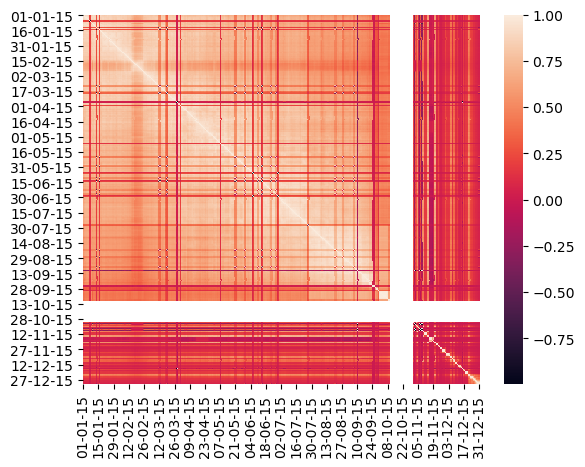

In [26]:
# Graficar mapa de calor de las correlaciones entre variables características:
sns.heatmap(X.corr())

Dado el predominio de los colores claros en la gráfica, concluimos que existe mucha correlación entre las variables características. Esto tiene sentido, porque recordemos que cada una es el consumo de energía de los hogares para  cada día de 2015.

Esto nos lleva a la conclusión de que tal vez sería prudente aplicar en los datos la técnica de aprendizaje no supervisado "Análisis de Componentes Principales". Una de las muchas ventajas de esta técnica es que elimina todo rastro de correlación entre variables, lo cual incluye potenciales problemas de multicolinealidad.

#### **Escalado / Normalizado de datos**

Para el entrenamiento de los modelos, parte integral de la estrategia es el escalado o la normalización de datos. Más adelante, evaluaremos ambos para ver cuál nos entrega mejores métricas.

In [5]:
# Escalado de datos:
from sklearn.preprocessing import scale

X_scaled = scale(X)
X_train_scaled, X_test_scaled, y_train, y_test = train_test_split(X_scaled, y.values,
                                                                  test_size=.3, random_state =123)

In [8]:
# Normalizado de datos:
from sklearn.preprocessing import normalize

X_norm = normalize(X)
X_train_norm, X_test_norm, y_train, y_test = train_test_split(X_norm, y.values,
                                                              test_size=.3, random_state =123)

#### **Análisis de Componentes Principales**

Previamente, habíamos notado alta correlación entre las variables características. Por tanto, implementaremos PCA en la estrategia y revisaremos si esta técnica mejora el desempeño de los modelos.

In [6]:
# PCA para datos escalados:
pca = PCA()
X_scaled_pca = pca.fit_transform(X_scaled)
exp_variance = pca.explained_variance_ratio_

# Número mínimo de componentes principales que acumulan al menos el XX% de varianza:
requested_variance = 0.975
exp_variance_cum_sum = np.cumsum(exp_variance)
n_components = np.where(exp_variance_cum_sum >= requested_variance)[0][0] + 1
print(f"Núm. de componentes principales con {requested_variance*100}% de varianza: ", n_components)

X_scaled_pca = X_scaled_pca[:, :n_components]
print(X_scaled_pca.shape)

X_train_scaled_pca, X_test_scaled_pca, y_train, y_test = train_test_split(X_scaled_pca, y.values,
                                                                          test_size=.3, random_state =123)


Núm. de componentes principales con 97.5% de varianza:  84
(9957, 84)


<AxesSubplot:>

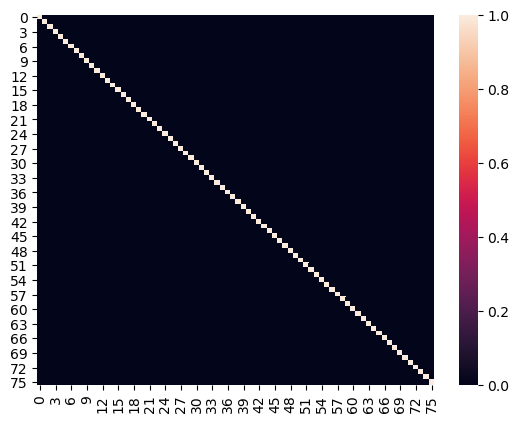

In [31]:
# Revisar correlación de datos escalados con PCA:
sns.heatmap(pd.DataFrame(X_scaled_pca).corr())

In [10]:
# PCA para datos normalizados:
pca = PCA()
X_norm_pca = pca.fit_transform(X_norm)
exp_variance = pca.explained_variance_ratio_

# Número mínimo de componentes principales que acumulan al menos el XX% de varianza:
requested_variance = 0.975 # 0.97 Parece ser un buen número
exp_variance_cum_sum = np.cumsum(exp_variance)
n_components = np.where(exp_variance_cum_sum >= requested_variance)[0][0] + 1
print(f"Núm. de componentes principales con {requested_variance*100}% de varianza: ", n_components)

X_norm_pca = X_norm_pca[:, :n_components]
print(X_norm_pca.shape)

X_train_norm_pca, X_test_norm_pca, y_train, y_test = train_test_split(X_norm_pca, y.values, test_size=.3, random_state =123)

Núm. de componentes principales con 97.5% de varianza:  77
(9957, 77)


#### **Remuestro (resultados)**

Aunque hemos omitido el código en este notebook, reportamos que como parte de la experimentación hemos efectuado remuestreo de la clase subrepresentada, es decir, de aquellos hogares en el dataset etiquetados como "defraudadores" `CHK_STATE==1`. Originalmente, el dataset tiene una proporción de alrededor 1:7 en la relación de hogares etiquetados como "defraudadores" versus "no defraudadores", respectivamente. Se ha inspeccionado el desempeño del algoritmo Regresión Logística en términos de recall y precisión, con proporiciones desde 1:7 hasta 1:3. 

**Conclusión:**  La técnica de sobremuestreo de la clase minoritaria no es necesaria ni conveniente para este dataset específico. Las razones son:

1) El sobremuestro de la clase minoritaria (1) no solo que no mejoró, sino que empeoró las métricas de precisión y clasificación, como se observa en el gráfico abajo.
2) Tanto recall como precisión ponderados, especificadas en los modelos a continuación, toman en consideración el desbalance de clases.
3) El remuestreo extremo de una de las clases no es una técnica apropiada pues la muestra dejaría de representar a la población original.


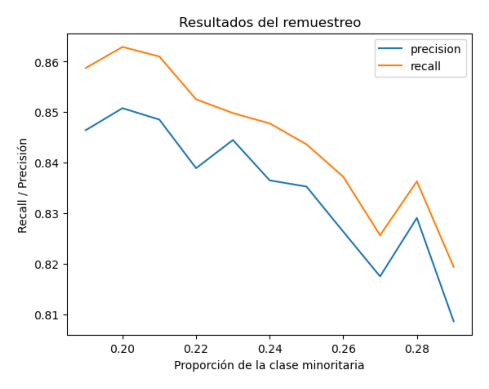

In [13]:
# Observar el efecto del remuestro de la clase minoritaria en Precision y Recall:
img = plt.imread('resample_results.png')
plt.axis('off')
plt.imshow(img)

### **Entrenamiento y evaluación de modelos clasificadores**

El primer paso es crear una función que, en pocas líneas de código, obtenga Recall, Precisión y MSE de cada algoritmo implementado con scikit-learn.

In [7]:
# Crear la función de obtención de métricas del modelo:
def get_model_metrics(model_instance, X_train, X_test, y_train, y_test):
    
    # Ajustar el modelo y predecir:
    model_instance.fit(X_train, y_train)
    y_pred = model_instance.predict(X_test)
    
    #Calcular métricas de exhaustividad y precisión:
    recall = recall_score(y_test, y_pred, average='weighted')
    precision = precision_score(y_test, y_pred, average='weighted')
    
    # Calcular el valor de MSE de validación cruzada: 
    cv_mse = -cross_val_score(model_instance, X_train, y_train, cv=5, 
                              scoring='neg_mean_squared_error', n_jobs=-1).mean()
    
    # Predecir el modelo con los datos de entrenamiento y con los de evaluación:
    y_pred_train = model_instance.predict(X_train)
    y_pred_test = model_instance.predict(X_test)

    # Calcular el MSE de los datos de entrenamiento y evaluación:
    train_mse = mean_squared_error(y_train, y_pred_train)
    test_mse = mean_squared_error(y_test, y_pred_test)
    
    return {'recall':recall, 'precision':precision, 'cv_mse':cv_mse,
            'train_mse':train_mse, 'test_mse':test_mse}

In [9]:
# Crear instancias de algoritmos clasificadores a comparar:
lr = LogisticRegression(solver='newton-cg')
knn = KNeighborsClassifier()
dtc = DecisionTreeClassifier(random_state=123)
rfc = RandomForestClassifier(random_state=123)
gbc = GradientBoostingClassifier(random_state=123)
svc = SVC(random_state=123)
xgbc = xgb.XGBClassifier(objective='binary:logistic', n_estimators=10, seed=123)

classifiers = {'lr':lr, 'knn':knn, 'dtc':dtc, 'rfc':rfc, 'gbc': gbc, 'svc':svc, 'xgbc':xgbc}

In [35]:
# Ajustar modelos utilizando la fórmula personalizada get_model_metrics() sobre los datos crudos:
clf_adj = {}

for clf_name, clf in classifiers.items():
    clf_adj[clf_name] = get_model_metrics(clf, X_train, X_test, y_train, y_test).values()

clf_df = pd.DataFrame(clf_adj,
                      index=['recall', 'precision', 'cv_mse', 'train_mse', 'test_mse']).transpose()
clf_df

,recall,precision,cv_mse,train_mse,test_mse
lr,0.875167,0.854037,0.134022,0.102884,0.124833
knn,0.859103,0.832304,0.136462,0.089109,0.140897
dtc,0.819612,0.821950,0.185105,0.002009,0.180388
rfc,0.879853,0.861634,0.120246,0.002009,0.120147
gbc,0.875837,0.854917,0.119816,0.081073,0.124163
svc,0.868809,0.867812,0.134453,0.132157,0.131191
xgbc,0.871486,0.847458,0.123834,0.063567,0.128514


In [19]:
clf_df.mean() # Imputación de la mediana

recall       0.878179
precision    0.868320
cv_mse       0.118607
train_mse    0.063916
test_mse     0.121821
dtype: float64

In [10]:
# Ajustar modelos utilizando la fórmula personalizada get_model_metrics() sobre los datos escalados con PCA:
clf_adj_scaled_pca = {}

for clf_name, clf in classifiers.items():
    clf_adj_scaled_pca[clf_name] = get_model_metrics(clf, X_train_scaled_pca,
                                                     X_test_scaled_pca, y_train, y_test).values()

clf_df_scaled_pca = pd.DataFrame(clf_adj_scaled_pca,
                      index=['recall', 'precision', 'cv_mse', 'train_mse', 'test_mse']).transpose()
clf_df_scaled_pca

,recall,precision,cv_mse,train_mse,test_mse
lr,0.883199,0.877931,0.118382,0.113359,0.116801
knn,0.889893,0.878712,0.107046,0.087961,0.110107
dtc,0.827979,0.826943,0.170612,0.002009,0.172021
rfc,0.893909,0.882532,0.109484,0.002009,0.106091
gbc,0.891232,0.878396,0.104463,0.071746,0.108768
svc,0.886546,0.879811,0.115225,0.104032,0.113454
xgbc,0.892570,0.880562,0.108481,0.056823,0.107430


In [11]:
clf_df_scaled_pca.mean()

recall       0.880761
precision    0.872127
cv_mse       0.119099
train_mse    0.062563
test_mse     0.119239
dtype: float64

In [39]:
# Ajustar modelos utilizando la fórmula personalizada get_model_metrics() sobre los datos normalizados con PCA:
clf_adj_norm_pca = {}

for clf_name, clf in classifiers.items():
    clf_adj_norm_pca[clf_name] = get_model_metrics(clf, X_train_norm_pca,
                                                     X_test_norm_pca, y_train, y_test).values()

clf_df_norm_pca = pd.DataFrame(clf_adj_norm_pca,
                      index=['recall', 'precision', 'cv_mse', 'train_mse', 'test_mse']).transpose()
clf_df_norm_pca

,recall,precision,cv_mse,train_mse,test_mse
lr,0.870817,0.854572,0.130722,0.129717,0.129183
knn,0.865462,0.840198,0.131296,0.086239,0.134538
dtc,0.826640,0.829408,0.182381,0.002009,0.173360
rfc,0.886212,0.872412,0.119242,0.002152,0.113788
gbc,0.885542,0.870336,0.116515,0.075764,0.114458
svc,0.879853,0.868131,0.123691,0.110633,0.120147
xgbc,0.877510,0.857827,0.121251,0.061989,0.122490


In [23]:
clf_df_norm_pca.mean()

recall       0.877988
precision    0.868615
cv_mse       0.119714
train_mse    0.060533
test_mse     0.122012
dtype: float64

En general, el desempeño de los modelos, tanto en términos de desempeño del recall como de la precisión, es ligeramente mejor para los datos escalados y con PCA, en comparación con las otras dos aproximaciones.

#### **Ranking del desempeño individual de los modelos, con datos escalados y con PCA**

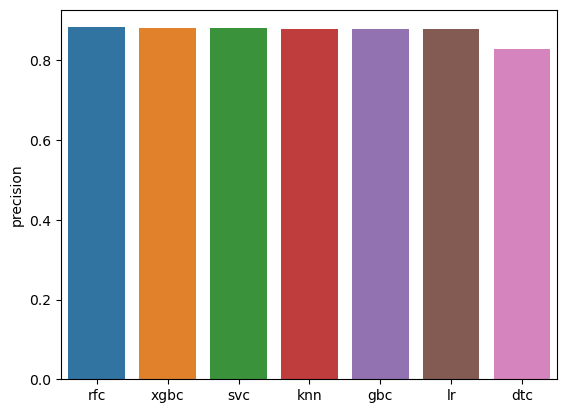

In [13]:
# Ranqueo de la precisión, de mejor  a peor:
sorted_index = clf_df_scaled_pca['precision'].sort_values(ascending=False).index
sns.barplot(x=clf_df_scaled_pca.index, y='precision', data=clf_df_scaled_pca, order=sorted_index)
plt.show()

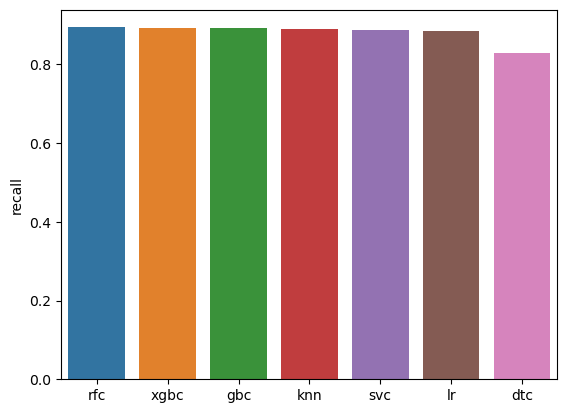

In [12]:
# Ranqueo del recall, de mejor  a peor:
sorted_index = clf_df_scaled_pca['recall'].sort_values(ascending=False).index
sns.barplot(x=clf_df_scaled_pca.index, y='recall', data=clf_df_scaled_pca, order=sorted_index)
plt.show()

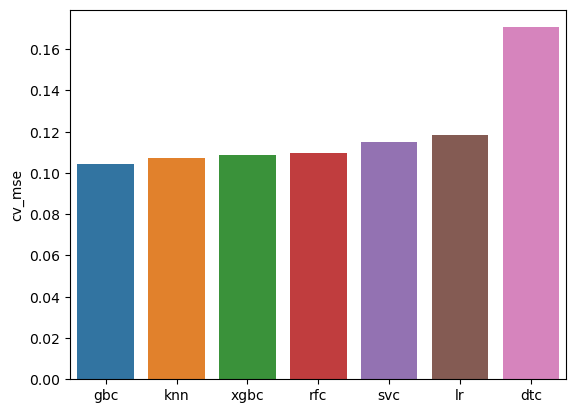

In [14]:
# Ranqueo del MSE de la validación cruzada, de mejor  a peor:
sorted_index = clf_df_scaled_pca['cv_mse'].sort_values(ascending=True).index
sns.barplot(x=clf_df_scaled_pca.index, y='cv_mse', data=clf_df_scaled_pca, order=sorted_index)
plt.show()

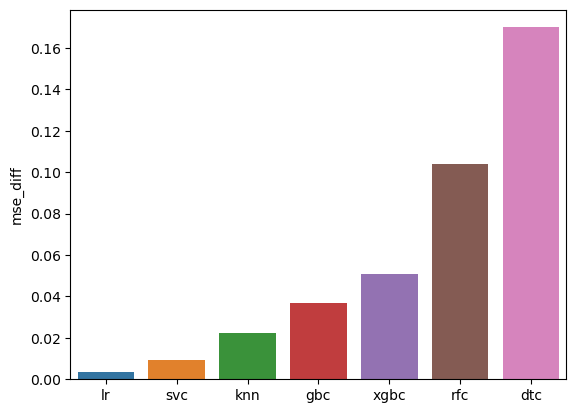

In [15]:
clf_df_scaled_pca['mse_diff'] = clf_df_scaled_pca['test_mse'] - clf_df_scaled_pca['train_mse']

# Ranqueo del sobreajuste, de menor a mayor:
sorted_index = clf_df_scaled_pca['mse_diff'].sort_values(ascending=True).index
sns.barplot(x=clf_df_scaled_pca.index, y='mse_diff', data=clf_df_scaled_pca, order=sorted_index)
plt.show()

**Conclusión:** Los resultados obtenidos con el `RandomForestClassifier` indican que este algoritmo tiene el mejor desempeño en la tarea de clasificación para este conjunto de datos en específico. En el otro extremo, el clasificador de árboles de decisión es el de peor desempeño en todos los aspectos.

Aunque el `RandomForestClassifier` tuvo el mejor desempeño clasificador en términos de Precisión  y también Recall, es necesario considerar que también es el segundo con mayor sobreajuste. Es importante tener en cuenta que los resultados de la validación cruzada y la evaluación del conjunto de prueba deben interpretarse en conjunto para evaluar la calidad del modelo. En general, se busca un modelo que tenga un bajo error de generalización y que no sobreajuste a los datos de entrenamiento.

Dado que los resultados obtenidos con el `RandomForestClassifier` son los más prometedores, trataremos de reducir el sobreajuste del modelo dsin afectar su capacidad clasificadora. Esto lo haremos mediante optimización de hiperparámetros.

#### **Ajuste de hiperparámetros para clasificador Random Forest**

In [28]:
# Definir el modelo
rf_grid = RandomForestClassifier(random_state=123)

# Definir el diccionario de hiperparámetros a ajustar con GridSearchCV
param_grid = {'n_estimators': [100, 125, 150], # Pred. 100
              'max_depth': [3, 5], # Pred. None
              'min_samples_split': [2, 5], # Pred. 2
              'min_samples_leaf': [1, 2, 4], # Pred. 1
              'max_features': ['sqrt', 'log2'] # Pred. auto
             } 

# Definir el objeto scorer personalizado para el recall
scoring = make_scorer(recall_score, average='weighted')

# Definir el objeto GridSearchCV y ajustar el modelo
grid_search = GridSearchCV(rf_grid, param_grid, cv=5, scoring=scoring, n_jobs=-1)
grid_search.fit(X_train_scaled_pca, y_train)

# Mejores hiperparámetros:
rf_best_params = grid_search.best_params_

# Imprimir los mejores hiperparámetros y la precisión promedio en la validación cruzada
print("Mejores hiperparámetros:", rf_best_params)
print("Recall promedio en la validación cruzada:", grid_search.best_score_)

# Mejores hiperparámetros: {'max_depth': None, 'max_features': 'auto', 'min_samples_leaf': 1, 
#'min_samples_split': 5, 'n_estimators': 150}

# Recall promedio en la validación cruzada: 0.902282060023421

Mejores hiperparámetros: {'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 150}
Recall promedio en la validación cruzada: 0.8938152537642094


In [17]:
# Ajustar el modelo de RandomForestClassifier con los hiperparámetros obtenidos para revisar sus métricas.
rfc_grid_params = RandomForestClassifier(
    n_estimators= 150,
    max_depth= None,
    min_samples_split= 2,
    min_samples_leaf= 2,
    max_features= 'sqrt',
    random_state=123)

# Obtener métricas del modelo resultante de GridSearchCV:
rfc_grid_metrics = get_model_metrics(rfc_grid_params, X_train_scaled_pca,
                                    X_test_scaled_pca, y_train, y_test)
rfc_grid_metrics

{'recall': 0.891566265060241,
 'precision': 0.8792472099595813,
 'cv_mse': 0.10618474623579055,
 'train_mse': 0.010331467929401636,
 'test_mse': 0.10843373493975904}

En el modelo ajustado con los mejores hiperparámetros, seleccionados con `GridSearchCV`, aún observamos sobreajuste, ya que `train_mse` > `test_mse`. Por este motivo, decidimos hacer una selección manual sobre los hiperparámetros ya escogidos.

In [18]:
# Ajustar el modelo de RandomForestClassifier manualmente, basado en los resultados obtenidos con GridSearchCV:
rfc_tuned_params = RandomForestClassifier(
    n_estimators= 300,
    max_depth= 5,
    min_samples_split= 2,
    min_samples_leaf= 1,
    max_features= 'sqrt',
    random_state=123)

# Obtener métricas del modelo:
rf_tuned_metrics = get_model_metrics(rfc_tuned_params, X_train_scaled_pca,
                                    X_test_scaled_pca, y_train, y_test)
rf_tuned_metrics

{'recall': 0.8835341365461847,
 'precision': 0.880611918757581,
 'cv_mse': 0.11823845606388161,
 'train_mse': 0.0984359305495767,
 'test_mse': 0.11646586345381527}

**Conclusión:** Con la selección manual basada en los resultados de `GridSearchCV`, las métricas de generalización mejoraron sustancialmente. Por su parte, la Precisión mejoró modestamente. Hemos logrado un modelo de `RandomForestClassifier` equilibrado con un desempeño superior a los previamente vistos.

### **Experimentación con algoritmos de ensamble**

El objuetivo de este apartado es determinar si podemos alcanzar mejores modelos que el logrado con `RandomForestClassifier` con modelos de ensamble. Para esto, hemos seleccionado dos modelos de ensamble: `VotingClassifier` y `BaggingClassifier`.

`VotingClassifier` es un estimador que combina múltiples clasificadores para realizar una predicción final mediante votación. Es decir, cada clasificador proporciona su predicción y se elige la clase más votada como la predicción final del modelo. Para el modelo creado con `VotingClassifier`, incluiremos todos los algoritmos revisados previamente, incluyendo `RandomForestClassifier` con parámetros optimizados.  

Por su parte, `BaggingClassifier` utiliza el método de Bootstrap Aggregating para mejorar la precisión de los modelos de aprendizaje automático. El modelo crea múltiples conjuntos de datos de entrenamiento a partir del conjunto de datos original mediante muestreo aleatorio con reemplazo, y entrena un clasificador diferente en cada uno de estos conjuntos. Luego, las predicciones de cada clasificador se combinan mediante votación o promedio para producir una predicción final. En este caso, tomaremos el modelo de `RandomForestClassifier` optimizado como estimador base.

#### **VotingClassifier**

In [19]:
# Crear instancias de algoritmos clasificadores a comparar:
lr = LogisticRegression(solver='newton-cg')
knn = KNeighborsClassifier(n_neighbors=3)
dtc = DecisionTreeClassifier(random_state=123)
rfc = rfc_tuned_params = RandomForestClassifier(
    n_estimators= 300,
    max_depth= 5,
    min_samples_split= 2,
    min_samples_leaf= 1,
    max_features= 'sqrt',
    random_state=123)
gbc = GradientBoostingClassifier(random_state=123)
svc = SVC(random_state=123)
xgbc = xgb.XGBClassifier(objective='binary:logistic', n_estimators=10, seed=123)

classifiers = [('lr', lr), ('knn', knn), ('dtc', dtc), ('rfc', rfc),
               ('gbc', gbc), ('svc', svc), ('xgbc', xgbc)]

In [20]:
# Crear el clasificador de votación
voting_clf = VotingClassifier(estimators=classifiers, voting='hard')

# Obtener métricas del modelo:
voting_clf_metrics = get_model_metrics(voting_clf, X_train_scaled_pca,
                                    X_test_scaled_pca, y_train, y_test)
voting_clf_metrics

{'recall': 0.8895582329317269,
 'precision': 0.8814651479805768,
 'cv_mse': 0.10675863432761265,
 'train_mse': 0.07590759075907591,
 'test_mse': 0.11044176706827309}

#### **BaggingClassifier**

In [21]:
# Crear un clasificador de árbol de decisión como estimador base
base_estimator = RandomForestClassifier(
    n_estimators= 300,
    max_depth= 5,
    min_samples_split= 2,
    min_samples_leaf= 1,
    max_features= 'sqrt',
    random_state=123)

# Crear el clasificador Bagging
bagging_clf = BaggingClassifier(base_estimator=base_estimator, n_estimators=10, random_state=123)

# Aplicar función personalizada get_model_metrics()
bagging_clf_metrics = get_model_metrics(bagging_clf, X_train_scaled_pca, 
                                        X_test_scaled_pca, y_train, y_test)
bagging_clf_metrics

{'recall': 0.8828647925033467,
 'precision': 0.8813676718242976,
 'cv_mse': 0.12082187943200322,
 'train_mse': 0.10216673841297173,
 'test_mse': 0.11713520749665328}

### **Experimentación con Redes Neuronales Artificiales**

Antes de comparar el desempeño de los modelos de ensamble con el de `RandomForestClassifier` optimizado, decidimos experimentar un poco con redes neuronales. Crearemos dos modelos: una red neuronal secuencial densa (DNN) y uno de mayor complejidad, una red neuronal convolucional unidimensional (CNN).

#### **Red neuronal secuencial densa (DNN)**

In [22]:
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.metrics import Recall, Precision

In [23]:
# Crear la red neuronal
dnn = Sequential()
dnn.add(Dense(64, input_dim=X_train_scaled_pca.shape[1], activation='relu'))
dnn.add(Dropout(0.25))
dnn.add(Dense(32, activation='relu'))
dnn.add(Dense(16, activation='relu'))
dnn.add(Dense(1, activation='sigmoid'))

# Compilar el modelo
dnn.compile(loss='binary_crossentropy',
            optimizer='sgd',
            metrics=['mse', Recall(), Precision()])

# Entrenar la red neuronal
dnn.fit(X_train_scaled_pca, y_train, epochs=100, batch_size=32, validation_split=0.2, verbose=1)

Epoch 1/100
175/175 [==============================] - 2s 4ms/step - loss: 0.5145 - mse: 0.1505 - recall: 0.1105 - precision: 0.3308 - val_loss: 0.4508 - val_mse: 0.1307 - val_recall: 0.1534 - val_precision: 0.4754
Epoch 2/100
175/175 [==============================] - 0s 2ms/step - loss: 0.4102 - mse: 0.1206 - recall: 0.1537 - precision: 0.6436 - val_loss: 0.4132 - val_mse: 0.1172 - val_recall: 0.1958 - val_precision: 0.5873
Epoch 3/100
175/175 [==============================] - 0s 2ms/step - loss: 0.3882 - mse: 0.1116 - recall: 0.1703 - precision: 0.6442 - val_loss: 0.3912 - val_mse: 0.1093 - val_recall: 0.1905 - val_precision: 0.6316
Epoch 4/100
175/175 [==============================] - 0s 3ms/step - loss: 0.3650 - mse: 0.1052 - recall: 0.1842 - precision: 0.7474 - val_loss: 0.3753 - val_mse: 0.1039 - val_recall: 0.1587 - val_precision: 0.6522
Epoch 5/100
175/175 [==============================] - 0s 3ms/step - loss: 0.3566 - mse: 0.1010 - recall: 0.1944 - precision: 0.7612 - val_l

Epoch 39/100
175/175 [==============================] - 0s 2ms/step - loss: 0.2831 - mse: 0.0784 - recall: 0.4130 - precision: 0.7812 - val_loss: 0.3246 - val_mse: 0.0834 - val_recall: 0.3915 - val_precision: 0.6727
Epoch 40/100
175/175 [==============================] - 0s 2ms/step - loss: 0.2786 - mse: 0.0785 - recall: 0.4193 - precision: 0.7728 - val_loss: 0.3273 - val_mse: 0.0836 - val_recall: 0.3968 - val_precision: 0.6881
Epoch 41/100
175/175 [==============================] - 0s 2ms/step - loss: 0.2776 - mse: 0.0786 - recall: 0.4155 - precision: 0.7730 - val_loss: 0.3251 - val_mse: 0.0834 - val_recall: 0.3915 - val_precision: 0.6852
Epoch 42/100
175/175 [==============================] - 0s 2ms/step - loss: 0.2775 - mse: 0.0774 - recall: 0.4168 - precision: 0.7646 - val_loss: 0.3219 - val_mse: 0.0838 - val_recall: 0.3810 - val_precision: 0.6923
Epoch 43/100
175/175 [==============================] - 1s 3ms/step - loss: 0.2753 - mse: 0.0781 - recall: 0.4117 - precision: 0.7807 - 

Epoch 77/100
175/175 [==============================] - 0s 2ms/step - loss: 0.2529 - mse: 0.0712 - recall: 0.5070 - precision: 0.7917 - val_loss: 0.3285 - val_mse: 0.0806 - val_recall: 0.4603 - val_precision: 0.6850
Epoch 78/100
175/175 [==============================] - 0s 2ms/step - loss: 0.2515 - mse: 0.0714 - recall: 0.4790 - precision: 0.7725 - val_loss: 0.3296 - val_mse: 0.0812 - val_recall: 0.4444 - val_precision: 0.6774
Epoch 79/100
175/175 [==============================] - 0s 2ms/step - loss: 0.2496 - mse: 0.0698 - recall: 0.5006 - precision: 0.8024 - val_loss: 0.3295 - val_mse: 0.0812 - val_recall: 0.4392 - val_precision: 0.6803
Epoch 80/100
175/175 [==============================] - 0s 2ms/step - loss: 0.2474 - mse: 0.0697 - recall: 0.5019 - precision: 0.7869 - val_loss: 0.3334 - val_mse: 0.0816 - val_recall: 0.4550 - val_precision: 0.6772
Epoch 81/100
175/175 [==============================] - 0s 2ms/step - loss: 0.2508 - mse: 0.0708 - recall: 0.4867 - precision: 0.7913 - 

In [30]:
from sklearn.metrics import classification_report

# Obtener las predicciones del modelo DNN
y_pred = dnn.predict(X_test_scaled_pca)
y_pred = [1 if y>=0.5 else 0 for y in y_pred]

# Obtener el informe de clasificación
dnn_report = classification_report(y_test, y_pred, output_dict=True)

# Obtener el recall ponderado del clasificador XGBoost
dnn_weighted_recall = dnn_report['weighted avg']['recall']
dnn_weighted_precision = dnn_report['weighted avg']['precision']

# Obtener las predicciones del modelo para MSE:
y_train_pred = dnn.predict(X_train_scaled_pca)
y_train_pred = [1 if y>=0.5 else 0 for y in y_train_pred]

# Evaluar el modelo DNN y obtener las métricas
dnn_mse = dnn.evaluate(X_test_scaled_pca, y_test)[1]
dnn_train_mse = mean_squared_error(y_train, y_train_pred)
dnn_test_mse = mean_squared_error(y_test, y_pred)

# Crear un diccionario de métricas para DNN:
dnn_metrics_dict = {'recall': dnn_weighted_recall,
                   'precision': dnn_weighted_precision,
                   'cv_mse': dnn_mse,
                   'train_mse':dnn_train_mse,
                   'test_mse': dnn_test_mse}
dnn_metrics_dict

94/94 [==============================] - 0s 2ms/step - loss: 0.3154 - mse: 0.0841 - recall: 0.4163 - precision: 0.7250


{'recall': 0.8962516733601071,
 'precision': 0.8851589521599256,
 'cv_mse': 0.08408176898956299,
 'train_mse': 0.08537810302769408,
 'test_mse': 0.1037483266398929}

#### **Red neuronal convolucional unidimensional (CNN)**

In [26]:
from keras.layers import Conv1D, Flatten, Reshape
from keras.callbacks import EarlyStopping

In [27]:
# Crear la red neuronal convolucional unidimensional:
cnn = Sequential()
cnn.add(Reshape((X_train_scaled_pca.shape[1], 1), input_shape=(X_train_scaled_pca.shape[1],)))
cnn.add(Conv1D(32, 3, activation='relu'))
cnn.add(Dropout(0.25))
cnn.add(Flatten())
cnn.add(Dense(32, activation='relu'))
#cnn.add(Dense(16, activation='relu'))
cnn.add(Dense(1, activation='sigmoid'))

# Compilar el modelo
cnn.compile(loss='binary_crossentropy',
            optimizer='sgd',
            metrics=['mse'])

# Entrenar la red neuronal
cnn.fit(X_train_scaled_pca, y_train, epochs=100, batch_size=32, validation_split=0.2, verbose=1)

Epoch 1/100
175/175 [==============================] - 2s 6ms/step - loss: 0.4576 - mse: 0.1399 - val_loss: 0.3569 - val_mse: 0.1030
Epoch 2/100
175/175 [==============================] - 1s 4ms/step - loss: 0.3470 - mse: 0.0989 - val_loss: 0.3342 - val_mse: 0.0968
Epoch 3/100
175/175 [==============================] - 1s 4ms/step - loss: 0.3330 - mse: 0.0940 - val_loss: 0.3209 - val_mse: 0.0927
Epoch 4/100
175/175 [==============================] - 1s 4ms/step - loss: 0.3165 - mse: 0.0898 - val_loss: 0.3189 - val_mse: 0.0922
Epoch 5/100
175/175 [==============================] - 1s 5ms/step - loss: 0.3107 - mse: 0.0884 - val_loss: 0.3161 - val_mse: 0.0895
Epoch 6/100
175/175 [==============================] - 1s 4ms/step - loss: 0.3087 - mse: 0.0874 - val_loss: 0.3170 - val_mse: 0.0898
Epoch 7/100
175/175 [==============================] - 1s 4ms/step - loss: 0.3076 - mse: 0.0867 - val_loss: 0.3088 - val_mse: 0.0873
Epoch 8/100
175/175 [==============================] - 1s 4ms/step - 

In [31]:
# Obtener las predicciones del modelo CNN
y_pred = cnn.predict(X_test_scaled_pca)
y_pred = [1 if y>=0.5 else 0 for y in y_pred]

# Obtener el informe de clasificación
cnn_report = classification_report(y_test, y_pred, output_dict=True)

# Obtener el recall ponderado del clasificador XGBoost
cnn_weighted_recall = cnn_report['weighted avg']['recall']
cnn_weighted_precision = cnn_report['weighted avg']['precision']

# Obtener las predicciones del modelo para MSE:
y_train_pred = cnn.predict(X_train_scaled_pca)
y_train_pred = [1 if y>=0.5 else 0 for y in y_train_pred]

# Evaluar el modelo CNN y obtener las métricas
cnn_mse = cnn.evaluate(X_test_scaled_pca, y_test)[1]
cnn_train_mse = mean_squared_error(y_train, y_train_pred)
cnn_test_mse = mean_squared_error(y_test, y_pred)

# Crear un diccionario de métricas para CNN:
cnn_metrics_dict = {'recall': cnn_weighted_recall,
                   'precision': cnn_weighted_precision,
                   'cv_mse': cnn_mse,
                   'train_mse':cnn_train_mse,
                   'test_mse': cnn_test_mse}
cnn_metrics_dict


94/94 [==============================] - 0s 2ms/step - loss: 0.3059 - mse: 0.0812


{'recall': 0.8972556894243642,
 'precision': 0.8867924816139566,
 'cv_mse': 0.08122765272855759,
 'train_mse': 0.07978189123260152,
 'test_mse': 0.10274431057563588}

Finalmente, comparamos en conjunto los modelos de mayor complejidad creados.

In [33]:
# Crear un DataFrame de modelos complejos:
complex_models_df = pd.DataFrame([rf_tuned_metrics, voting_clf_metrics, bagging_clf_metrics,
                                  dnn_metrics_dict, cnn_metrics_dict],
                                 index=['rf_tuned', 'voting_clf', 'bagging_clf', 'dnn', 'cnn'])
complex_models_df

,recall,precision,cv_mse,train_mse,test_mse
rf_tuned,0.883534,0.880612,0.118238,0.098436,0.116466
voting_clf,0.889558,0.881465,0.106759,0.075908,0.110442
bagging_clf,0.882865,0.881368,0.120822,0.102167,0.117135
dnn,0.896252,0.885159,0.084082,0.085378,0.103748
cnn,0.897256,0.886792,0.081228,0.079782,0.102744


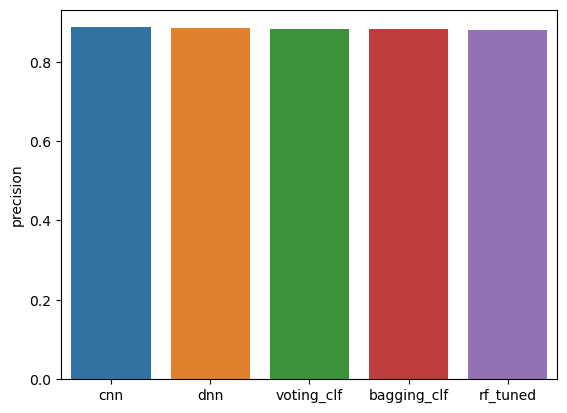

In [34]:
# Ranqueo de la precisión, de mejor  a peor:
sorted_index = complex_models_df['precision'].sort_values(ascending=False).index
sns.barplot(x=complex_models_df.index, y='precision', data=complex_models_df, order=sorted_index)
plt.show()

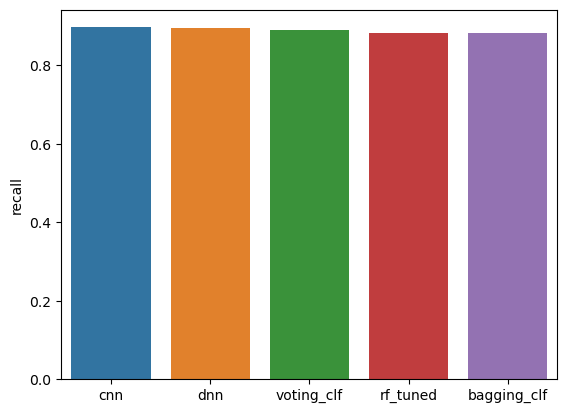

In [35]:
# Ranqueo del Recall, de mejor  a peor:
sorted_index = complex_models_df['recall'].sort_values(ascending=False).index
sns.barplot(x=complex_models_df.index, y='recall', data=complex_models_df, order=sorted_index)
plt.show()

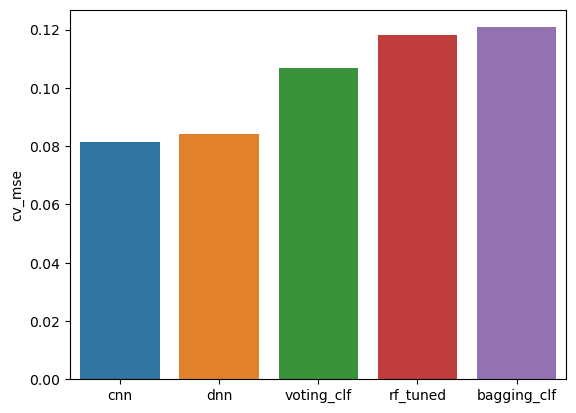

In [36]:
# Ranqueo del MSE de la validación cruzada, de mejor  a peor:
sorted_index = complex_models_df['cv_mse'].sort_values(ascending=True).index
sns.barplot(x=complex_models_df.index, y='cv_mse', data=complex_models_df, order=sorted_index)
plt.show()

#### **Conclusión:** Dentro del conjunto de modelos complejos, las redes neuronales entrenadas presentan mejor desempeño tanto en Precisión como en Recall, especialmente el modelo CNN. También tienen mejor capacidad de generalización, interpretada como la diferencia del MSE sobre el conjunto de entrenamiento y el de evaluación.